In [1]:
from transformers import pipeline
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# tested the following zero shot classifiers
resolution_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")   # found this to be the best, but uncomment others to test
#resolution_classifier = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-1")
#resolution_classifier = pipeline("zero-shot-classification", model="roberta-large-mnli")
#resolution_classifier = pipeline("zero-shot-classification", model="microsoft/deberta-large-mnli")
#resolution_classifier = pipeline("zero-shot-classification", model="MoritzLaurer/deberta-v3-large-zeroshot-v2.0")

Device set to use cpu


In [3]:
# path to the directory containing the transcript files
directory_path = 'simulated_transcripts'

In [4]:
# define resolution labels
labels = ["resolved", "not resolved"]

In [5]:
def extract_conversation_summary(file_path):
    """
    Given a path to a transcript file, opens it and extracts the "Member" side of the conversation.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract Member lines
    member_lines = [line.strip().split("Member: ", 1)[1] 
                              for line in lines if line.startswith("Member:")]
    
    return " ".join(member_lines) if member_lines else ""

def predict_resolution(file_path):
    """
    Given a path to a transcript file, predicts whether the issue being discussed was resolved or not.
    """
    conversation_summary = extract_conversation_summary(file_path)
    if not conversation_summary:
        return "unknown"  # handle cases where no relevant data is available
    
    # pass to the resolution classifier defined at the start of the scripts
    result = resolution_classifier(conversation_summary, labels)
    return result["labels"][0]  # result is the label with the highest score

def evaluate_resolution(directory):
    """
    Given a path to a directory containing call simulated transcripts, classifies each one as resolved or not resolved.
    Simulated transcripts filenames have the format <sentiment>_<resolution>_<int>.txt
    Sentiment can be 'positive', 'negative', or 'neutral'
    Resolution can be 'resolved' or 'notresolved'
    Int is a label from 1-10
    e.g., negative_notresolved_4.txt
    """
    true_labels = []
    predicted_labels = []

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)

            parts = filename.lower().split('_')     # split the filename by underscores
            if "resolved" in parts:
                true_label = "resolved"
            elif "notresolved" in parts:
                true_label = "not resolved"
            else:
                raise ValueError(f"Resolution status not found in filename: {filename}")            

            true_labels.append(true_label)
            
            # predict resolution
            predicted_label = predict_resolution(file_path)
            predicted_labels.append(predicted_label)

    return true_labels, predicted_labels

In [6]:
# run the evaluation
true_labels, predicted_labels = evaluate_resolution(directory_path)

Classification Report:
              precision    recall  f1-score   support

    resolved       0.71      0.73      0.72        30
not resolved       0.72      0.70      0.71        30

    accuracy                           0.72        60
   macro avg       0.72      0.72      0.72        60
weighted avg       0.72      0.72      0.72        60

Accuracy: 0.72


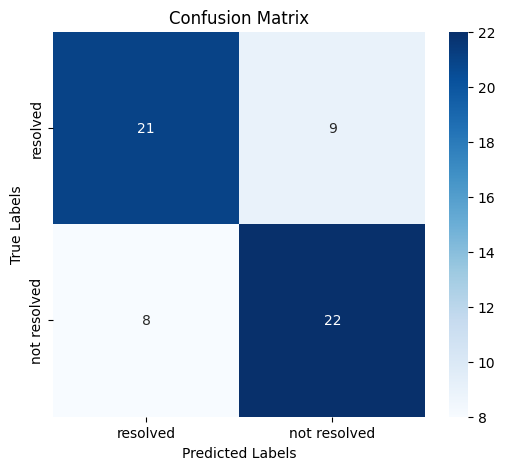

In [11]:
valid_classes = ["resolved", "not resolved"]  # calls can either be resolved or not resolved

# calculate and print the metrics to evaluate the model
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=valid_classes))

cm = confusion_matrix(true_labels, predicted_labels, labels=valid_classes)
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.2f}")

# plot a confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_classes, yticklabels=valid_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

#plt.savefig('confusion_matrix_resolution.png', dpi=300, bbox_inches='tight')  # uncomment to save the confusion matrix to a figure

plt.show()

In [8]:
# find the indices of false positives and false negatives
false_positives = [i for i in range(len(true_labels)) if true_labels[i] == 'not resolved' and predicted_labels[i] == 'resolved']
false_negatives = [i for i in range(len(true_labels)) if true_labels[i] == 'resolved' and predicted_labels[i] == 'not resolved']
file_list = os.listdir(directory_path)

In [9]:
print("false positives:")
for i in false_positives:
    print(file_list[i])

false positives:
negative_notresolved_10.txt
neutral_notresolved_10.txt
neutral_notresolved_2.txt
positive_notresolved_10.txt
positive_notresolved_3.txt
positive_notresolved_4.txt
positive_notresolved_6.txt
positive_notresolved_7.txt


In [10]:
print("false negatives:")
for i in false_negatives:
    print(file_list[i])

false negatives:
negative_resolved_10.txt
negative_resolved_2.txt
negative_resolved_5.txt
negative_resolved_6.txt
negative_resolved_7.txt
negative_resolved_8.txt
neutral_resolved_2.txt
neutral_resolved_5.txt
neutral_resolved_8.txt
